In [82]:
#!pip install mp-api --upgrade
import numpy as np
import scipy as sp
from mp_api.client import MPRester
#from pymatgen.ext.matproj import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import sys

In [83]:
mp_key = "zpmjFe6ZZzl6aqcqeGUTiXhaXzQXDSJl"
mp_id = "mp-961660"

In [84]:
with MPRester(mp_key) as m:
    el_bs = m.get_bandstructure_by_material_id(mp_id)


Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Bande interdite


In [130]:
band_gap = el_bs.get_band_gap()
print(f"Bande interdite: {band_gap['energy']} eV")

Bande interdite: 0.8605999999999998 eV


In [86]:
fig_el_bs = get_plot_bs(el_bs, plot_range=[-4,7])
fig_el_bs.show()

## Direction de dispersion

In [131]:
plot = BSPlotter(el_bs)
data = plot.bs_plot_data()
distances = data["distances"]
energies = data["energy"]["1"]
vbm_band_index = el_bs.get_vbm()["band_index"]
cbm_band_index = el_bs.get_cbm()["band_index"]
print(vbm_band_index)
print(cbm_band_index)

defaultdict(<class 'list'>, {<Spin.up: 1>: [13, 14]})
defaultdict(<class 'list'>, {<Spin.up: 1>: [15]})


Text(0, 0.5, 'E-Ef (eV)')

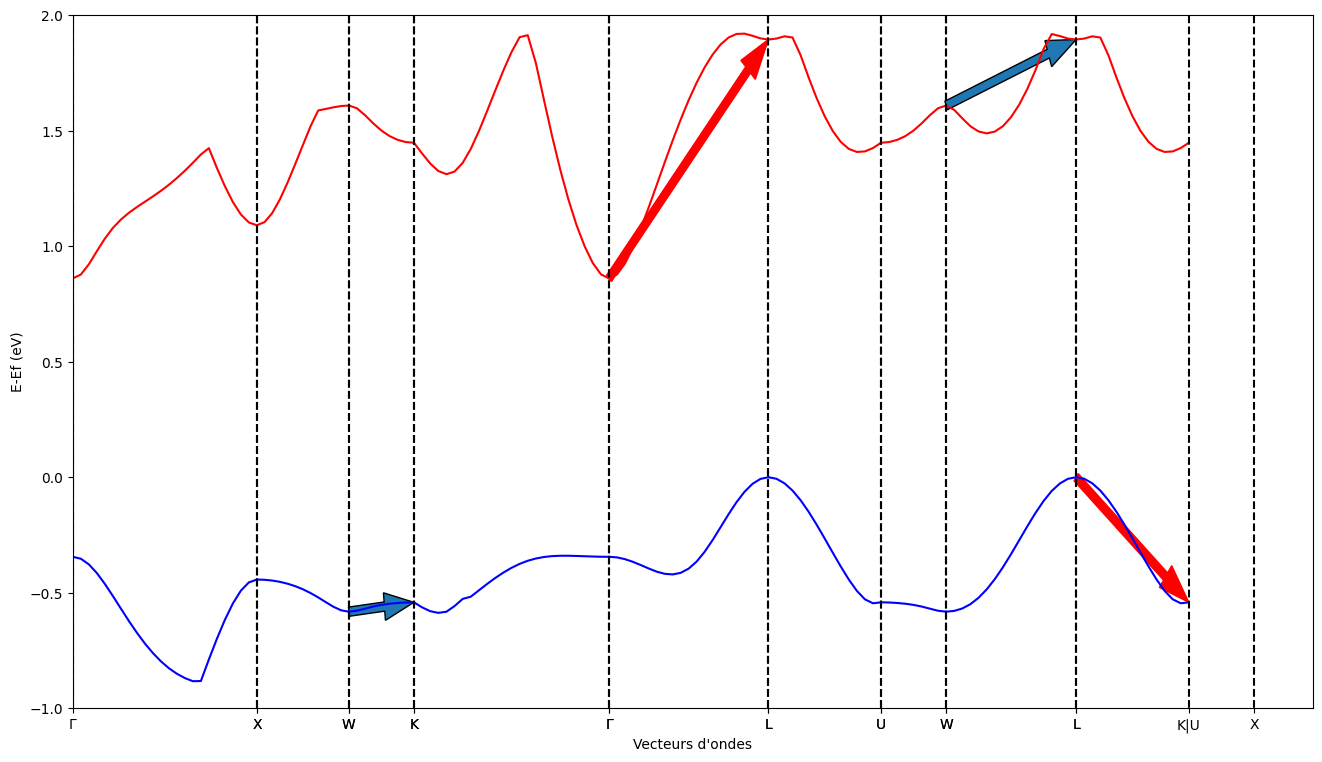

In [132]:
fig, axis = plt.subplots(figsize = (16,9))
for i in range(len(data)):
    plt.plot(distances[i],energies[i][15],"r")
    plt.plot(distances[i],energies[i][14],"b")
points = data["ticks"]["distance"]

plt.vlines(points,-2,3,color="black", linestyle="--")
plt.xlim(0)
plt.ylim(-1,2)
axis.set_xticks(points)
axis.set_xticklabels(["Γ"," ","X","","W","","K","","Γ","","L","","U","","W","", "L","K|U","X"])


cond_max = 0
val_max = 0
cond_min = sys.float_info.max
val_min = sys.float_info.max
for i in range(len(distances)):
    dk = distances[i][-1]-distances[i][0]
    dEc = energies[i][15][-1]-energies[i][15][0]
    dEv = energies[i][14][-1]-energies[i][14][0]
    
    if abs(dEc/dk) >  cond_max:
        cond_max = abs(dEc/dk)
        i_cond_max = i
    elif abs(dEc/dk) < cond_min:
        cond_min = abs(dEc/dk)
        i_cond_min = i
    if abs(dEv/dk) > val_max:
        val_max = abs(dEv/dk)
        i_val_max = i
    elif abs(dEv/dk) < val_min:
        val_min = abs(dEv/dk)
        i_val_min = i


plt.arrow(distances[i_cond_max][0],energies[i_cond_max][15][0],distances[i_cond_max][-1]-distances[i_cond_max][0],energies[i_cond_max][15][-1]-energies[i_cond_max][15][0],length_includes_head=True,width=0.04,color = "red")
plt.arrow(distances[i_cond_min][0],energies[i_cond_min][15][0],distances[i_cond_min][-1]-distances[i_cond_min][0],energies[i_cond_min][15][-1]-energies[i_cond_min][15][0],length_includes_head=True,width=0.04)
plt.arrow(distances[i_val_max][0],energies[i_val_max][14][0],distances[i_val_max][-1]-distances[i_val_max][0],energies[i_val_max][14][-1]-energies[i_val_max][14][0],length_includes_head=True,width=0.04,color = 'red')
plt.arrow(distances[i_val_min][0],energies[i_val_min][14][0],distances[i_val_min][-1]-distances[i_val_min][0],energies[i_val_min][14][-1]-energies[i_val_min][14][0],length_includes_head=True,width=0.04)

plt.xlabel("Vecteurs d'ondes")
plt.ylabel("E-Ef (eV)")

Les flèches rouges représente les dispersions maximales tandis que les flèches bleues représentent les dispersion minimale de la bande correspondante.

## Masse effective 

L'idée ici est de fit un polynome du second degré autour du maximum de la bande de vlaance maxumum et du minimum de la bande de conduction minimum. Ainsi la dérivée seconde de ce polynome peut être obtenu, permettant de calculer la masse effcetive.

In [133]:
hbar = sp.constants.hbar
A = sp.constants.angstrom
eV = sp.constants.electron_volt


points_kc = [distances[i_cond_max-1][-2],  distances[i_cond_max][0],  distances[i_cond_max+1][2]]
points_ec = [energies[i_cond_max-1][15][-2],  distances[i_cond_max][0],  energies[i_cond_max+1][15][2]]

poly_cond = np.polyfit(points_kc,points_ec,2)


points_kv = [distances[i_val_max-1][-3],distances[i_val_max][0],distances[i_val_max+1][3]]
points_ev = [energies[i_val_max-1][14][-3],energies[i_val_max][14][0],energies[i_val_max+1][14][3]]

poly_val = np.polyfit(points_kv,points_ev,2)

In [134]:
me_cond = hbar**2/(2*poly_cond[0])/eV/(A**2)
me_val = hbar**2/(2*poly_val[0])/eV/(A**2)

print(f"Masse effective à la base de la première bande de conduction: {me_cond} kg")
print(f"Masse effective au sommet de la dernière bande de valence: {me_val} kg")


Masse effective à la base de la première bande de conduction: -7.832613456189309e-32 kg
Masse effective au sommet de la dernière bande de valence: -3.810558699669458e-30 kg
